This notebook evaluate the noise robustness of the trained model in the paper_results_reproduction.ipynb script. The models are those of the paper "Sub-mW Keyword Spotting on an MCU: Analog Binary Feature Extration and Bynary Neural Networks" by Cerutti et al. (2022) published on IEEE Transactions on Circuits and Systems.

The noise source are:
- White noise.
- Pink noise.
- Bubble noise (from the Noisex-92 database).
- Different type of urban noise which each noise present in foreground and background (from the UrbanSoundDataset). The audio samples from the UrbanSoundDataset have been selected manually.

In [ ]:
import torch
from torchModel import test_model_with_confusion_matrix, test_model_accuracy
from ModelsArchitecture import BinarizedInputNetwork, ConvNet , BinarizedWeightNetwork
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
KEYWORDS =  list(set(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'] + ['unknown', 'silence']))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TESTSET_PATH = '/home/luciano/Downloads/speech_commands_test_set_v0.02/'

SAMPLE_RATE = 16000
BATCH_SIZE = 16
N_MELS = 64
N_FFT = 512
POWER = 2.0
F_MIN = 50.0
F_MAX = 7500.0
HOP_LENGTH=round(SAMPLE_RATE*0.01)
WIN_LENGTH=round(SAMPLE_RATE*0.025)
DURATION_SEC = 1.0

In [3]:
# load models
input_shape = (1, 64, 101)  # Example input shape, adjust as needed
num_classes = len(KEYWORDS)  # Example number of classes, adjust as needed

full_precision_model = ConvNet().to(device)
full_precision_model.load_state_dict(torch.load("full_precision.pth"))

BinaryWeights_model = BinarizedWeightNetwork(input_shape, num_classes).to(device)
BinaryWeights_model.load_state_dict(torch.load("BinaryWeights.pth"))

full_binary_model = BinarizedInputNetwork(input_shape, num_classes).to(device)
full_binary_model.load_state_dict(torch.load("full_binary_model.pth"))

/tmp/ipykernel_85750/511158711.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_precision_model.load_state_dict(torch.load("full_precision.pth"))
/tmp/ipykernel_8575

<All keys matched successfully>

# Add noise to signals

class definitions

In [4]:
import torch
import torchaudio
import numpy as np
from spectrogram import AudioDataset
import scipy.signal as signal

class AddNoiseOnTestset(AudioDataset):
    """
    This class adds noise to the spectrogram audio data.
    """
    def __init__(self, audio_path, 
                 n_mels, n_fft,hop_length,
                 win_length,f_min,f_max,
                 power,sample_rate,duration_seconds,
                 keywords, device,noise_type="white",snr_db=3.0):
        
        TEST_LIST = "testing_list.txt"
        with open(audio_path+TEST_LIST, 'r') as f:
            audio_list = f.read().splitlines()

        super().__init__(audio_path, audio_list,sample_rate,duration_seconds,keywords,device)
        self.noise_type = noise_type
        self.snr_db = snr_db
        # white, pink, babble and classes from the UrbanSoundsDataset
        self.noise_type_allowed = ['white',
                                   'pink',
                                   'babble',
                                   'air_conditioner_background',
                                   'car_horn_background',
                                   'children_playing_background',
                                   'dog_bark_background',
                                    'drilling_background',
                                    'engine_idling_background',
                                    'gun_shot_background',
                                    'jackhammer_background',
                                    'siren_background',
                                    'street_music_background',
                                    'air_conditioner_foreground',
                                   'car_horn_foreground',
                                   'children_playing_foreground',
                                   'dog_bark_foreground',
                                    'drilling_foreground',
                                    'engine_idling_foreground',
                                    'gun_shot_foreground',
                                    'jackhammer_foreground',
                                    'siren_foreground',
                                    'street_music_foreground']

        assert self.noise_type in self.noise_type_allowed, "Noise type not allowed"  # TODO: implement more noise types
        self.noise_signal = self.__load_noise_signal()

        transformation = torchaudio.transforms.MelSpectrogram(
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            win_length=win_length,
            f_min=f_min,
            f_max=f_max,
            center=True,
            power = power,
            sample_rate=sample_rate,
        )
        self.mel_spectrogram = transformation.to(self._device)
        

    def __load_noise_signal(self):
        if self.noise_type == 'white':
            noise_signal = self.__white_noise()
        elif self.noise_type == 'pink':
            noise_signal = self.__pink_noise()
        elif self.noise_type == 'babble':
            noise_signal = self.__babble_noise()
        else:
            noise_signal = self.__urban_sounds_noise()
        return noise_signal

    def __getitem__(self, index):
        signal, label = super().__getitem__(index)
        # Add noise to the signal
        signal_with_noise = torchaudio.functional.add_noise(waveform=torch.squeeze(signal),
                                                            noise=torch.squeeze(self.noise_signal),
                                                            snr=torch.tensor(self.snr_db),
                                                            lengths=None)
        signal_with_noise = torch.unsqueeze(signal_with_noise, 0)
        signal_with_noise = signal_with_noise.to(self._device)
        mel_spectro = self.mel_spectrogram(signal_with_noise)
        # Convert to decibels
        mel_spectro = torchaudio.transforms.AmplitudeToDB()(mel_spectro)
        return mel_spectro, label
        
    def __white_noise(self):
        noise = torch.randn(self._num_samples,device=self._device)
        return noise
    
    def __pink_noise(self):
        # Generate white noise
        self._num_samples
        white_noise = torch.randn(self._num_samples)

        # Apply a filter to shape the white noise into pink noise
        b, a = signal.butter(4, 0.05, 'highpass')  # High-pass filter to remove DC component
        filtered_noise = signal.lfilter(b, a, white_noise)
        
        fft = torch.fft.rfft(torch.tensor(filtered_noise))
        frequencies = torch.fft.rfftfreq(self._num_samples, d=1/self._sample_rate)
        pink_filter = 1 / torch.sqrt(np.abs(frequencies + 1e-10))  # Avoid division by zero
        pink_filter[0] = 0  # Remove DC component
        # pink_filter = pink_filter.to(self._device)
        pink_fft = fft * pink_filter

        # Inverse FFT to get the time-domain signal
        pink_noise = torch.fft.irfft(pink_fft)
        pink_noise = pink_noise.to(torch.float32)

        return pink_noise.to(self._device)
    
    def __babble_noise(self):
        noise,sr = torchaudio.load("./noise/noisex-92/babble.wav")
        
        noise = self._resample_if_necessary(noise, sr)
        noise = noise.to(self._device)
        noise = self._cut_if_necessary(noise)
        noise = self._right_pad_if_necessary(noise)
        return noise

    def __urban_sounds_noise(self): #TODO: read the wav file name from the csv file
        wav_dict = {
                    'air_conditioner_background' : "177621-0-0-0.wav",
                    'car_horn_background' : "132073-1-0-0.wav",
                    'children_playing_background' : "135776-2-0-32.wav",
                    'dog_bark_background' : "102106-3-0-0.wav",
                    'drilling_background' : "17913-4-1-0.wav",
                    'engine_idling_background' : "46918-5-0-0.wav",
                    'gun_shot_background' : "135527-6-0-0.wav",
                    'jackhammer_background' : "180937-7-3-0.wav",
                    'siren_background' : "106905-8-0-0.wav",
                    'street_music_background' : "132016-9-0-0.wav",
                    'air_conditioner_foreground' : "127873-0-0-0.wav",
                    'car_horn_foreground' : "145577-1-0-0.wav",
                    'children_playing_foreground' : "105415-2-0-1.wav",
                    'dog_bark_foreground' : "101415-3-0-2.wav",
                    'drilling_foreground' : "103199-4-0-0.wav",
                    'engine_idling_foreground' : "103258-5-0-0.wav",
                    'gun_shot_foreground' : "102305-6-0-0.wav",
                    'jackhammer_foreground' : "103074-7-0-0.wav",
                    'siren_foreground' : "157867-8-0-0.wav",
                    'street_music_foreground' : "108041-9-0-11.wav"
                    }
        
        noise,sr = torchaudio.load("./noise/UrbanSound8K/" + wav_dict[self.noise_type])
        
        noise = self._resample_if_necessary(noise, sr)
        noise = noise.to(self._device)
        noise = self._cut_if_necessary(noise)
        noise = self._right_pad_if_necessary(noise)
        noise = self._mix_down_if_necessary(noise)
        return noise
    
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

In [5]:
# load the whole dataset in memory
def load_in_memory(data_set):
    all_data = []
    all_labels = []
    for data, label in data_set:
        all_data.append(data)
        all_labels.append(label)
    return all_data, all_labels

In [4]:
# run the experiments for all type of noise at different snr ratios
csv_file = "./noiseResults.csv"

snr_list = [30, 27 , 24, 21, 18, 15, 12, 9, 6, 3, 0]
noise_type_allowed = ['white',
                    'pink',
                    'babble',
                    'air_conditioner_background',
                    'car_horn_background',
                    'children_playing_background',
                    'dog_bark_background',
                    'drilling_background',
                    'engine_idling_background',
                    'gun_shot_background',
                    'jackhammer_background',
                    'siren_background',
                    'street_music_background',
                    'air_conditioner_foreground',
                    'car_horn_foreground',
                    'children_playing_foreground',
                    'dog_bark_foreground',
                    'drilling_foreground',
                    'engine_idling_foreground',
                    'gun_shot_foreground',
                    'jackhammer_foreground',
                    'siren_foreground',
                    'street_music_foreground']

if not(os.path.exists(csv_file)):

    results_df = pd.DataFrame(columns=["noise_type","snr","accuracyFullPrecision","accuracyBinaryWeight","accuracyFullBinary"])

    

    for snr in snr_list:
        for noise_type in noise_type_allowed:
            # Create the noisy test set with the current combination of SNR and noise type
            noisy_testset = AddNoiseOnTestset(
                audio_path=TESTSET_PATH,
                n_mels=N_MELS,
                n_fft=N_FFT, 
                hop_length=HOP_LENGTH,
                win_length=WIN_LENGTH,
                f_min=F_MIN,
                f_max=F_MAX,
                power=POWER,
                sample_rate=SAMPLE_RATE,
                duration_seconds=DURATION_SEC,
                keywords=KEYWORDS,
                device=device,
                noise_type=noise_type,
                snr_db=snr
            )
            
            # Load the noisy test set into memory
            all_data, all_labels = load_in_memory(noisy_testset)
            test_tensor = TensorDataset(torch.stack(all_data), torch.tensor(all_labels))
            test_loader = DataLoader(test_tensor, batch_size=BATCH_SIZE, shuffle=False)
            
            # Test the models with the current combination of SNR and noise type
            acc_full_precision, _ , _ = test_model_accuracy(test_loader, full_precision_model, device)
            acc_binary_weight, _ , _ = test_model_accuracy(test_loader, BinaryWeights_model, device)
            acc_full_binary, _ , _ = test_model_accuracy(test_loader, full_binary_model, device)

            # Append the results to the results_df DataFrame
            temp_df = pd.DataFrame({
                    "noise_type": noise_type,
                    "snr": snr,
                    "accuracyFullPrecision": acc_full_precision,
                    "accuracyBinaryWeight": acc_binary_weight,
                    "accuracyFullBinary": acc_full_binary
                    },index=[0])
            
            results_df = pd.concat([results_df ,temp_df], ignore_index=True)

    results_df.to_csv(csv_file,index=False)
else:
    results_df = pd.read_csv(csv_file)

# plot results

In [5]:
# compute average value for the noise source of the UrbanSound dataset
filtered_part1_df = results_df[results_df['noise_type'].isin(['white', 'pink', 'babble'])]
filtered_part2_df = pd.DataFrame()

all_noise_types = results_df['noise_type'].unique()
noise_types_to_exclude = ['white', 'pink', 'babble']
complement_df = results_df[~results_df['noise_type'].isin(noise_types_to_exclude)]


for snr in snr_list:
    aux =complement_df[complement_df['snr']==snr]

    temp_df = pd.DataFrame({
            "noise_type": "urban_sound_avg",
            "snr": snr,
            "accuracyFullPrecision": aux["accuracyFullPrecision"].mean(),
            "accuracyBinaryWeight": aux["accuracyBinaryWeight"].mean(),
            "accuracyFullBinary": aux["accuracyFullBinary"].mean()
            },index=[0])
    
    filtered_part2_df = pd.concat([filtered_part2_df ,temp_df], ignore_index=True)

results_summary_df = pd.concat([filtered_part1_df ,filtered_part2_df], ignore_index=True)

## Compare all noise sources in a specific model

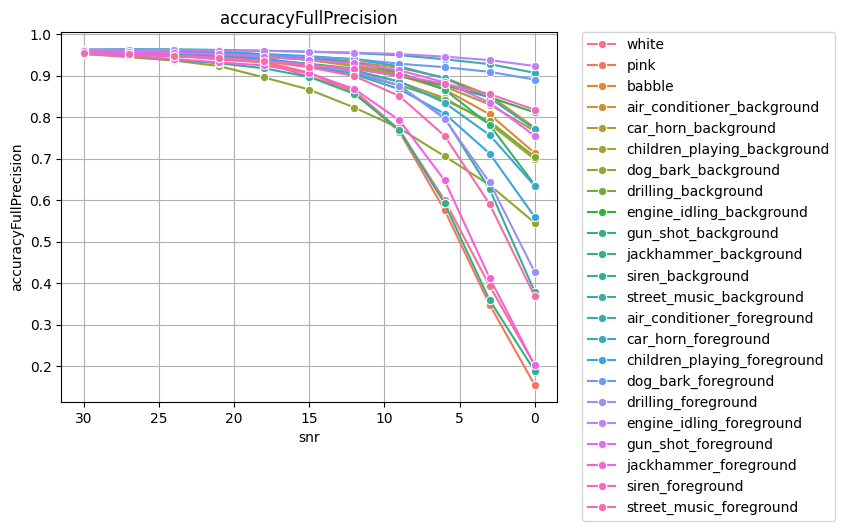

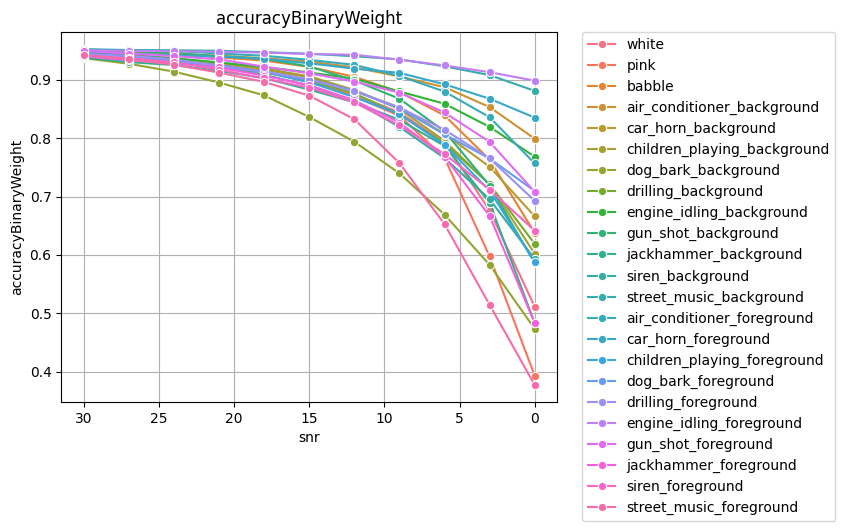

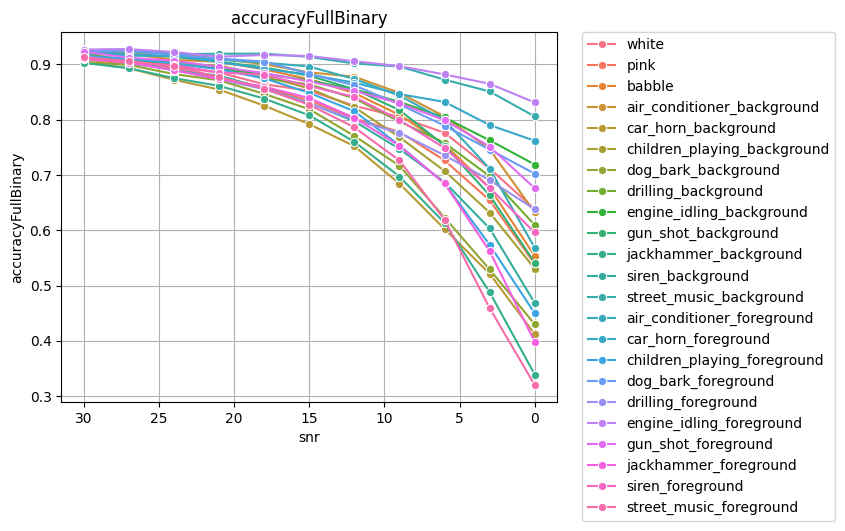

In [12]:
for idx_model in ['accuracyFullPrecision',"accuracyBinaryWeight","accuracyFullBinary"]: 

    sns.lineplot(data=results_df, x='snr', y=idx_model, hue='noise_type', marker='o')
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.title(idx_model)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

## Compare white, pink, buble and urbansound sources in a specific model

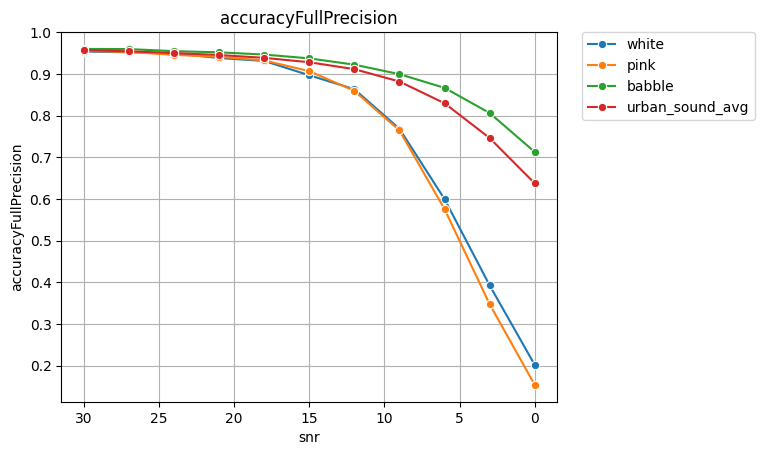

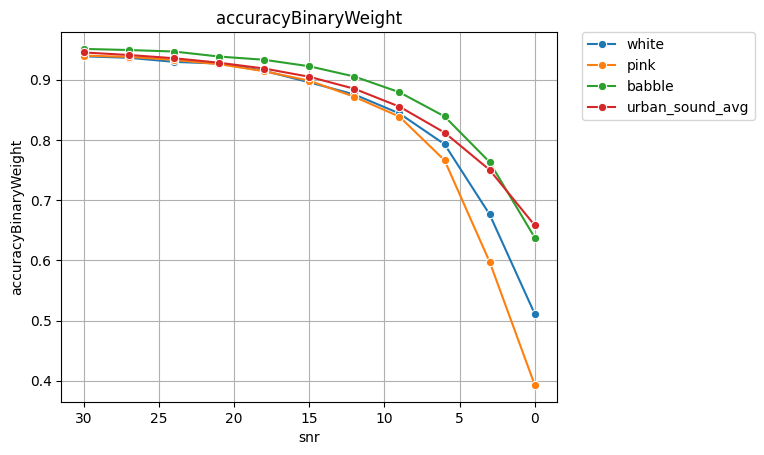

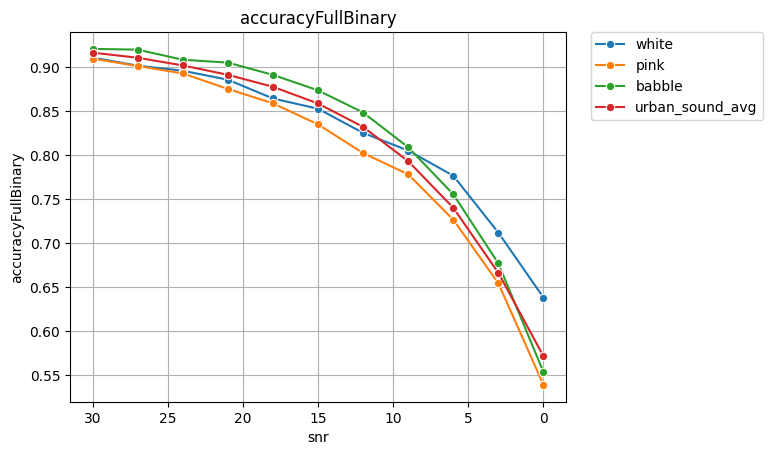

In [13]:
for idx_model in ['accuracyFullPrecision',"accuracyBinaryWeight","accuracyFullBinary"]: 
    sns.lineplot(data=results_summary_df, x='snr', y=idx_model, hue='noise_type', marker='o')
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.title(idx_model)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()

## Compare the different model performance for each single noise source

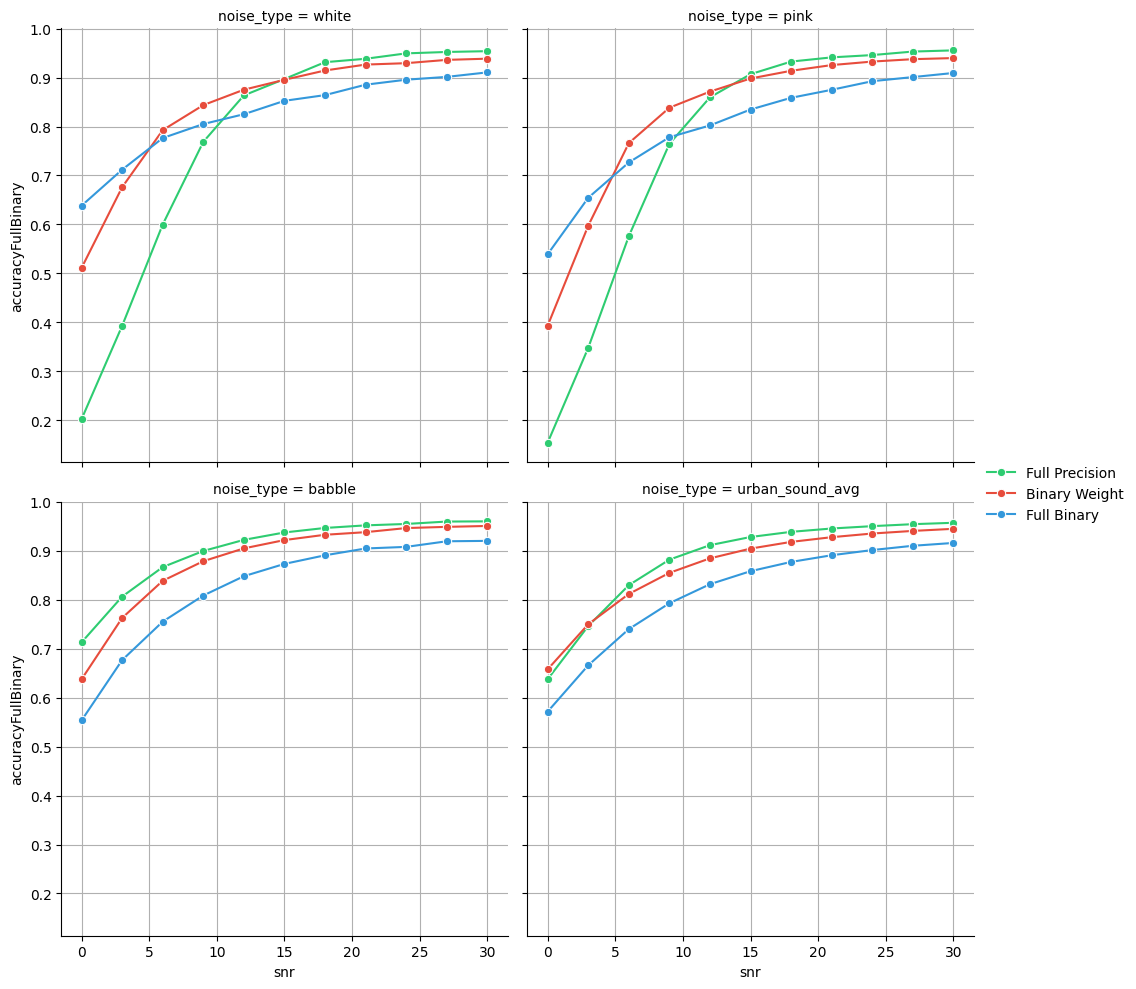

In [7]:
g = sns.FacetGrid(results_summary_df, col='noise_type', height=5, aspect=1,col_wrap=2)

colors = {
    'accuracyFullPrecision': '#2ecc71',  # green
    'accuracyBinaryWeight': '#e74c3c',   # red
    'accuracyFullBinary': '#3498db'      # blue
}


g.map_dataframe(sns.lineplot, x='snr', y='accuracyFullPrecision', marker='o', label='Full Precision',color=colors['accuracyFullPrecision'])
g.map_dataframe(sns.lineplot, x='snr', y='accuracyBinaryWeight', marker='o', label='Binary Weight',color=colors['accuracyBinaryWeight'])
g.map_dataframe(sns.lineplot, x='snr', y='accuracyFullBinary', marker='o', label='Full Binary',color=colors['accuracyFullBinary'])

g.add_legend()
for ax in g.axes.flat:
    ax.invert_xaxis()
    ax.grid(True)

plt.show()

zoom-in for better visualization

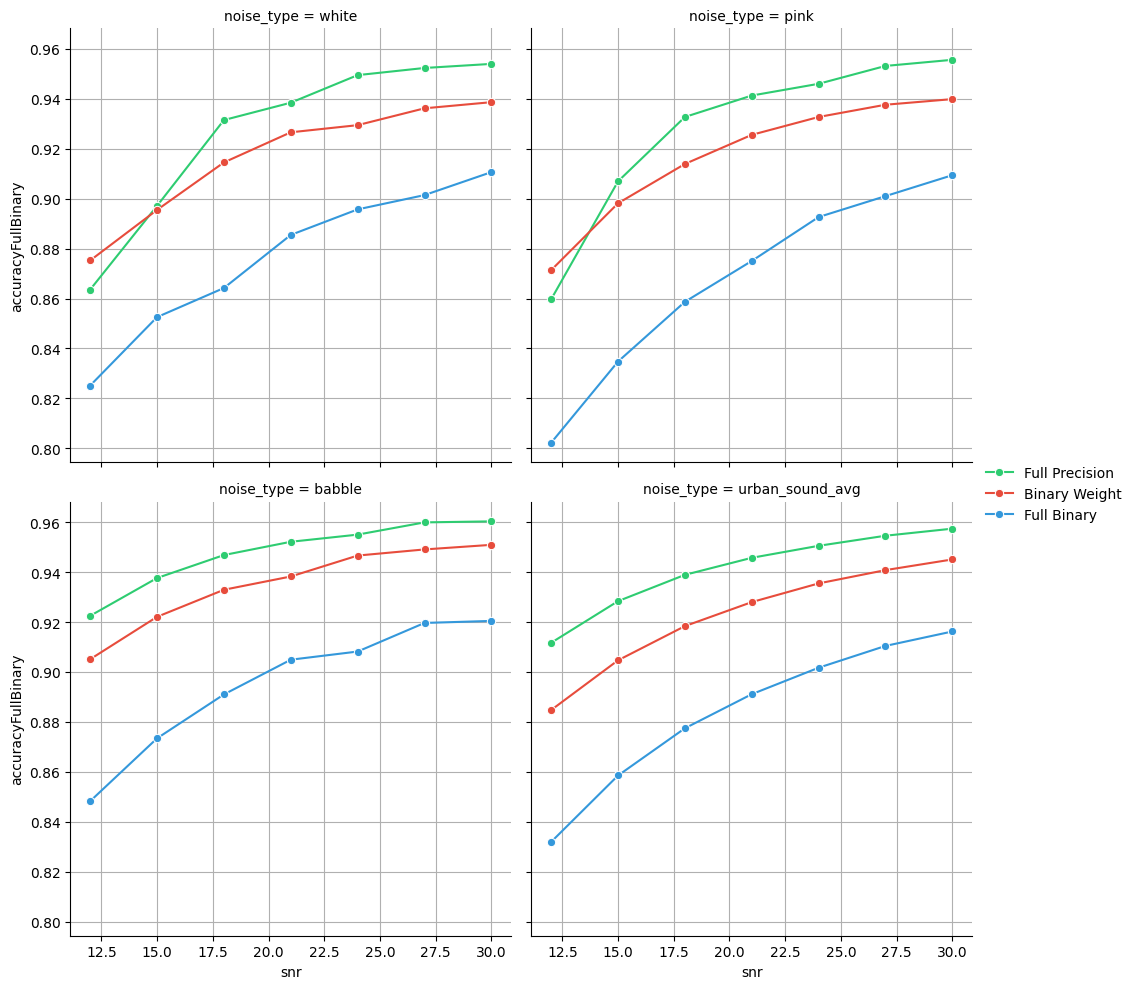

In [ ]:
# Filter the dataframe for SNR > 10
filtered_df = results_summary_df[results_summary_df['snr'] > 10]

g = sns.FacetGrid(filtered_df, col='noise_type', height=5, aspect=1, 
                  col_wrap=2)


# Plot each accuracy metric with specific colors
g.map_dataframe(sns.lineplot, x='snr', y='accuracyFullPrecision', 
                marker='o', label='Full Precision', color=colors['accuracyFullPrecision'])
g.map_dataframe(sns.lineplot, x='snr', y='accuracyBinaryWeight', 
                marker='o', label='Binary Weight', color=colors['accuracyBinaryWeight'])
g.map_dataframe(sns.lineplot, x='snr', y='accuracyFullBinary', 
                marker='o', label='Full Binary', color=colors['accuracyFullBinary'])

g.add_legend()
for ax in g.axes.flat:
    ax.invert_xaxis()
    ax.grid(True)
    
plt.show()